# Environment setup
Follow the tutorial about how to utilize Google Colab but **don't install PyTorch** as mentioned in the blog post.

Turkish:
https://medium.com/deep-learning-turkiye/google-colab-ile-%C3%BCcretsiz-gpu-kullan%C4%B1m%C4%B1-30fdb7dd822e

English:
https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d



In [8]:
# This part probably will be enough for utilizing Drive in Colab
# but examine links above if you encounter with problems.
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


## Now, you will work on Architectural Heritage Elements Dataset and classify these elements into 10 categories

After having mounted the Jupyter Notebook to Google Drive, navigate the following address: https://drive.google.com/drive/folders/1PLXZYjGeaM1rekMKUTo8mlaaPeFOrBft?usp=sharing


Add this folder entirely to your Google Drive. If you have done it correctly, then you should be able to see *data* folder in your drive.

You can examine the dataset in the following address: https://old.datahub.io/dataset/architectural-heritage-elements-image-dataset


### Don't forget to choose the right runtime from the menu above. (GPU should be selected)

In [ ]:
!nvidia-smi
# This command should return some information about the GPU status if the runtime is right. 
# In addition to that, if you encounter memory issues, you can diagnose your model by this command.

Tue Dec 22 18:03:35 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### You are free to utilize Pytorch methods in this part of the homework. You will be using pretained models ResNet-50, DenseNet-121 and your own model.

In [2]:
# All libraries are already presented in Colab Servers, we don't need to install anything with pip
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"# import modules
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Pre-trained Models

You can find tutorials on how to load those models at pytorch.org . Don't forget to use pretrained=True if you wish to do finetuning.

In [3]:
# Load ResNet-50 and DenseNet-121 model seperately here

resnet = torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', pretrained=True)
densenet = torch.hub.load('pytorch/vision:v0.6.0', 'densenet121', pretrained=True)

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


## Your Model

Additionally, build your own model which is different from the other models, train on the Architectural Heritage Elements dataset.

In [ ]:
class YourModel(nn.Module):
    def __init__(self):
        # TO DO: Your neural network design
        super(YourModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 20, 9)
        self.conv2 = nn.Conv2d(20, 10, 9)  
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(10 * 50 * 50, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.relu3 = nn.ReLU()        
        self.relu4 = nn.ReLU()   
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.2)
        self.dropout3 = nn.Dropout(0.2)        
        self.dropout4 = nn.Dropout(0.2)       
        self.conv1_bn = nn.BatchNorm2d(20)
        self.conv2_bn = nn.BatchNorm2d(10)
    def forward(self, x):
        # TO DO: Your neural network design
        x = self.dropout1(self.pool(self.relu1(self.conv1_bn(self.conv1(x)))))#first conv
        x = self.dropout2(self.pool(self.relu2(self.conv2_bn(self.conv2(x)))))#second conv
        x = torch.reshape(x, (x.size()[0], -1))
        #print(x.shape)
        x = self.dropout3(self.relu3(self.fc1(x)))
        x = self.dropout4(self.relu4(self.fc2(x)))
        out = self.fc3(x)
        return out

model = YourModel()

In [ ]:
###  Here are some training parameters which you can tweak

learning_rate = 5e-3
regularization_rate = 1e-10
n_epochs = 20
use_gpu = True
test_every = 3
###
# You may want to tweak them too and you can use different parameter settings for different models. 
# These are just examples
optimizer = optim.SGD(params=model.parameters(), lr=learning_rate, weight_decay=0.001)
criteria = nn.CrossEntropyLoss()

## DataLoader

Here we provide you the codes for loading the train data, validation data and test data. Please ensure that you understood how PyTorch methods like ImageFolder, DataLoader and transformations work.

In [9]:
batch_size = 32
train_transforms = transforms.Compose([
            transforms.Resize(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])
val_transforms = transforms.Compose([
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])
test_transforms = transforms.Compose([
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])

train_dataset = ImageFolder('drive/My Drive/data/train', train_transforms)
val_dataset = ImageFolder('drive/My Drive/data/val', val_transforms)
test_dataset = ImageFolder('drive/My Drive/data/test', test_transforms)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=4, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, num_workers=4, shuffle=False)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, num_workers=4, shuffle=False)

# Train your own model

Don't forget to include appropriate regularizations. Choose appropriate set of hyperparameters such as Learning Rate etc. You may insert new cells.

In [ ]:
# It modifies the behaviour of modules like BatchNorm and Dropout for training purposes
# Use your own model
model.train()
if use_gpu:
    model.cuda()
    criteria.cuda()

# Some example diagnostics.

# Loss for every iteration
losses_iter_train = []
# Loss for epoch (averaging the iteration-wise loss)
losses_epoch_train = []
accuracy_iter_train = []
accuracy_epoch_train = []

losses_iter_val = []
losses_epoch_val = []
accuracy_iter_val = []
accuracy_epoch_val = []

# Write the training loop
for epoch in range(n_epochs): #number of epoch
    epoch_loss=0
    epoch_acc = 0
    for data in train_loader:
        
        optimizer.zero_grad()
        img, label = data #read data
        if use_gpu:
            img = img.cuda()
            label = label.cuda()
        outputs = model(img) #load to model
        _, predicted = torch.max(outputs.data, 1) #get prediction
        correct = (predicted == label).sum().item() #calculate accuracy
        loss = criteria(outputs, label) #calculate loss
        loss.backward() #backprop
        optimizer.step() #optimize

        accuracy_iter_train.append(correct/(len(label)))
        losses_iter_train.append(loss)
        epoch_loss += loss
        epoch_acc += correct/(len(label))
    losses_epoch_train.append(epoch_loss/(len(train_loader)))
    accuracy_epoch_train.append(epoch_acc/(len(train_loader)))
    print("Training Accuracy: {}, Training Loss: {}".format(epoch_acc/(len(train_loader)), epoch_loss/(len(train_loader))))
    
    
    if epoch % 3 == 1:
        with torch.no_grad():
            model.eval() #eval mode same for the validation
            epoch_acc = 0
            epoch_loss = 0
            for data in val_loader:              
              img, label = data
              if use_gpu:                
                img = img.cuda()
                label = label.cuda()
              outputs = model(img)
              _, predicted = torch.max(outputs, 1)
              correct = (predicted == label).sum().item()
              loss = criteria(outputs, label)

              accuracy_iter_val.append(correct/(len(label)))
              losses_iter_val.append(loss)

              epoch_loss += loss
              epoch_acc += correct/(len(label))
            for c in range(3):
              losses_epoch_val.append(epoch_loss/(len(val_loader)))
              accuracy_epoch_val.append(epoch_acc/(len(val_loader)))
            print("Validation Accuracy: {}, Validation Loss: {}".format(epoch_acc/(len(val_loader)), epoch_loss/(len(val_loader))))
            
            
    model.train()
    
        # Fill the rest...
        


Training Accuracy: 0.4080815018315018, Training Loss: 1.623008370399475
Training Accuracy: 0.5233516483516484, Training Loss: 1.3361438512802124
Validation Accuracy: 0.5394965277777778, Validation Loss: 1.3096507787704468
Training Accuracy: 0.5800518925518925, Training Loss: 1.179657220840454
Training Accuracy: 0.6379731379731379, Training Loss: 1.0376842021942139
Training Accuracy: 0.6668192918192918, Training Loss: 0.9490320682525635
Validation Accuracy: 0.6471354166666666, Validation Loss: 0.9918069243431091
Training Accuracy: 0.6915445665445665, Training Loss: 0.8836897015571594
Training Accuracy: 0.7087530525030525, Training Loss: 0.8235278725624084
Training Accuracy: 0.72748778998779, Training Loss: 0.7910330891609192
Validation Accuracy: 0.7044270833333334, Validation Loss: 0.8967052698135376
Training Accuracy: 0.7377136752136753, Training Loss: 0.7487807869911194
Training Accuracy: 0.7520604395604396, Training Loss: 0.7059669494628906
Training Accuracy: 0.7722069597069597, Trai

## Test your model

Measure the performance against test set. Complete the code below.

In [ ]:
# It modifies the behaviour of modules like BatchNorm and Dropout for test purposes
# Dropout no longer works when .eval() is called.
# BatchNorm uses the learned parameters

model.eval()
epoch_acc = 0
with torch.no_grad():
    for data in test_loader:
        img, label = data
        if use_gpu:
            img = img.cuda()
            label = label.cuda()
        outputs = model(img)
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == label).sum().item()
        epoch_acc += correct/(len(label))
    mymodel_testacc = epoch_acc/(len(test_loader))
    print("Test Accuracy: {}".format(epoch_acc/(len(test_loader))))
    # Fill the rest...

Test Accuracy: 0.6491477272727273


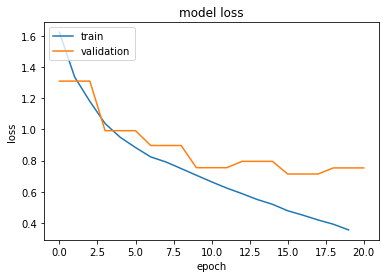

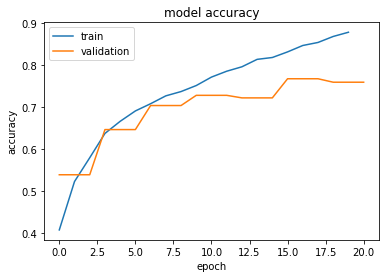

In [ ]:
plt.plot(losses_epoch_train)
plt.plot(losses_epoch_val)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(accuracy_epoch_train)
plt.plot(accuracy_epoch_val)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [42]:
class AlternateYourModel(nn.Module):
    def __init__(self):
        # TO DO: Your neural network design
        super(AlternateYourModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 9)
        self.conv2 = nn.Conv2d(6, 8, 9)  
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(8 * 50 * 50, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.relu3 = nn.ReLU()        
        self.relu4 = nn.ReLU()   
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.2)
        self.dropout3 = nn.Dropout(0.2)        
        self.dropout4 = nn.Dropout(0.2)       
        self.conv1_bn = nn.BatchNorm2d(6)
        self.conv2_bn = nn.BatchNorm2d(8)
    def forward(self, x):
        # TO DO: Your neural network design
        x = self.dropout1(self.pool(self.relu1(self.conv1_bn(self.conv1(x)))))#first conv
        x = self.dropout2(self.pool(self.relu2(self.conv2_bn(self.conv2(x)))))#second conv
        x = torch.reshape(x, (x.size()[0], -1))
        #print(x.shape)
        x = self.dropout3(self.relu3(self.fc1(x)))
        x = self.dropout4(self.relu4(self.fc2(x)))
        out = self.fc3(x)
        return out

alternatemodel = AlternateYourModel()

In [43]:
###  Here are some training parameters which you can tweak

learning_rate = 1e-3
regularization_rate = 1e-10
n_epochs = 45
use_gpu = True
test_every = 3
###
# You may want to tweak them too and you can use different parameter settings for different models. 
# These are just examples
optimizer = optim.SGD(params=alternatemodel.parameters(), lr=learning_rate, weight_decay=0.001)
criteria = nn.CrossEntropyLoss()

In [44]:
# It modifies the behaviour of modules like BatchNorm and Dropout for training purposes
# Use your own model
alternatemodel.train()
if use_gpu:
    alternatemodel.cuda()
    criteria.cuda()

# Some example diagnostics.

# Loss for every iteration
alternatemodel_losses_iter_train = []
# Loss for epoch (averaging the iteration-wise loss)
alternatemodel_losses_epoch_train = []
alternatemodel_accuracy_iter_train = []
alternatemodel_accuracy_epoch_train = []

alternatemodel_losses_iter_val = []
alternatemodel_losses_epoch_val = []
alternatemodel_accuracy_iter_val = []
alternatemodel_accuracy_epoch_val = []

# Write the training loop
for epoch in range(n_epochs): #number of epoch
    epoch_loss=0
    epoch_acc = 0
    for data in train_loader:
        
        optimizer.zero_grad()
        img, label = data #read data
        if use_gpu:
            img = img.cuda()
            label = label.cuda()
        outputs = alternatemodel(img) #load to model
        _, predicted = torch.max(outputs.data, 1) #get prediction
        correct = (predicted == label).sum().item() #calculate accuracy
        loss = criteria(outputs, label) #calculate loss
        loss.backward() #backprop
        optimizer.step() #optimize

        alternatemodel_accuracy_iter_train.append(correct/(len(label)))
        alternatemodel_losses_iter_train.append(loss)
        epoch_loss += loss
        epoch_acc += correct/(len(label))
    alternatemodel_losses_epoch_train.append(epoch_loss/(len(train_loader)))
    alternatemodel_accuracy_epoch_train.append(epoch_acc/(len(train_loader)))
    print("Training Accuracy: {}, Training Loss: {}".format(epoch_acc/(len(train_loader)), epoch_loss/(len(train_loader))))
    
    
    if epoch % 3 == 1:
        with torch.no_grad():
            alternatemodel.eval() #eval mode same for the validation
            epoch_acc = 0
            epoch_loss = 0
            for data in val_loader:              
              img, label = data
              if use_gpu:                
                img = img.cuda()
                label = label.cuda()
              outputs = alternatemodel(img)
              _, predicted = torch.max(outputs, 1)
              correct = (predicted == label).sum().item()
              loss = criteria(outputs, label)

              alternatemodel_accuracy_iter_val.append(correct/(len(label)))
              alternatemodel_losses_iter_val.append(loss)

              epoch_loss += loss
              epoch_acc += correct/(len(label))
            for c in range(3):
              alternatemodel_losses_epoch_val.append(epoch_loss/(len(val_loader)))
              alternatemodel_accuracy_epoch_val.append(epoch_acc/(len(val_loader)))
            print("Validation Accuracy: {}, Validation Loss: {}".format(epoch_acc/(len(val_loader)), epoch_loss/(len(val_loader))))
            
            
    alternatemodel.train()
    
        # Fill the rest...
        


Training Accuracy: 0.2732753357753358, Training Loss: 2.01798152923584
Training Accuracy: 0.3978556166056166, Training Loss: 1.6910779476165771
Validation Accuracy: 0.3684895833333333, Validation Loss: 1.7436175346374512
Training Accuracy: 0.4362408424908425, Training Loss: 1.5639512538909912
Training Accuracy: 0.4681013431013431, Training Loss: 1.467560052871704
Training Accuracy: 0.49217796092796096, Training Loss: 1.4038615226745605
Validation Accuracy: 0.5423177083333334, Validation Loss: 1.4177221059799194
Training Accuracy: 0.5230082417582418, Training Loss: 1.3314460515975952
Training Accuracy: 0.5414758852258852, Training Loss: 1.2830016613006592
Training Accuracy: 0.5563949938949939, Training Loss: 1.245598316192627
Validation Accuracy: 0.5531684027777778, Validation Loss: 1.36065673828125
Training Accuracy: 0.5826846764346764, Training Loss: 1.1904540061950684
Training Accuracy: 0.6022970085470086, Training Loss: 1.1350823640823364
Training Accuracy: 0.6117979242979243, Train

In [45]:
# It modifies the behaviour of modules like BatchNorm and Dropout for test purposes
# Dropout no longer works when .eval() is called.
# BatchNorm uses the learned parameters

alternatemodel.eval()
epoch_acc = 0
with torch.no_grad():
    for data in test_loader:
        img, label = data
        if use_gpu:
            img = img.cuda()
            label = label.cuda()
        outputs = alternatemodel(img)
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == label).sum().item()
        epoch_acc += correct/(len(label))
    myalternatemodel_testacc = epoch_acc/(len(test_loader))
    print("Test Accuracy: {}".format(epoch_acc/(len(test_loader))))
    # Fill the rest...

Test Accuracy: 0.5926339285714286


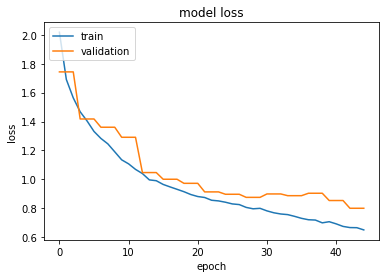

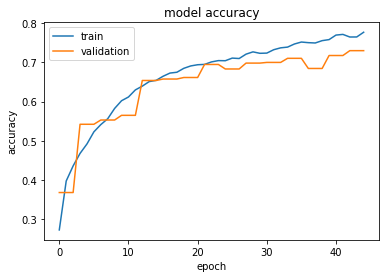

In [46]:
plt.plot(alternatemodel_losses_epoch_train)
plt.plot(alternatemodel_losses_epoch_val)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(alternatemodel_accuracy_epoch_train)
plt.plot(alternatemodel_accuracy_epoch_val)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

#### MyModel has got the higher accuracy than alternatemodel. So i trained withoutbatch norm and without dropout model with the MyModel. I also try alternate model too, in this model, even the alternate model has the similar loss and accuracy in val and train i got less test accuracy.

# ResNet-50
## Train ResNet-50

Avoid overfitting and underfitting as much as possible. **Try to get highest validation and test accuracy (at least 65%)**

In [5]:
# You can use the same training mechanism above. Now, you will use ResNet-50 as your model        
# It modifies the behaviour of modules like BatchNorm and Dropout for training purposes

for param in resnet.parameters():
    param.requires_grad = False


    
resnet.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.1),
                                 
                                 nn.Linear(512, 64),
                                 nn.ReLU(),
                                 nn.Dropout(0.1),
                                 nn.Linear(64, 10),
                                 nn.LogSoftmax(dim=1))

criteria = nn.CrossEntropyLoss()

batch_size = 32
learning_rate = 2e-5
regularization_rate = 1e-10
n_epochs = 45
use_gpu = True
test_every = 3
# Observe that all parameters are being optimized
optimizer = optim.SGD(resnet.fc.parameters(), lr=learning_rate, momentum=0.9)

resnet.train()
if use_gpu:
    resnet.cuda()
    criteria.cuda()

# Some example diagnostics.

# Loss for every iteration
resnet_losses_iter_train = []
# Loss for epoch (averaging the iteration-wise loss)
resnet_losses_epoch_train = []
resnet_accuracy_iter_train = []
resnet_accuracy_epoch_train = []

resnet_losses_iter_val = []
resnet_losses_epoch_val = []
resnet_accuracy_iter_val = []
resnet_accuracy_epoch_val = []

# Write the training loop
for epoch in range(n_epochs):
    epoch_loss=0
    epoch_acc = 0
    for data in train_loader:
        optimizer.zero_grad()
        img, label = data
        if use_gpu:
            img = img.cuda()
            label = label.cuda()
        outputs = resnet(img)
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == label).sum().item()
        loss = criteria(outputs, label)
        loss.backward()
        optimizer.step()

        resnet_accuracy_iter_train.append(correct/(len(label)))
        resnet_losses_iter_train.append(loss)
        epoch_loss += loss
        epoch_acc += correct/(len(label))
    resnet_losses_epoch_train.append(epoch_loss/(len(train_loader)))
    resnet_accuracy_epoch_train.append(epoch_acc/(len(train_loader)))
    print("Epoch: {}, Training Accuracy: {}, Training Loss: {}".format(epoch, epoch_acc/(len(train_loader)), epoch_loss/(len(train_loader))))

    if epoch % 3 == 1:
        with torch.no_grad():
            resnet.eval()
            epoch_acc=0
            epoch_loss=0
            for data in val_loader:              
              img, label = data
              if use_gpu:                
                img = img.cuda()
                label = label.cuda()
              outputs = resnet(img)
              _, predicted = torch.max(outputs, 1)
              correct = (predicted == label).sum().item()
              loss = criteria(outputs, label)

              resnet_accuracy_iter_val.append(correct/(len(label)))
              resnet_losses_iter_val.append(loss)
              epoch_loss += loss
              epoch_acc += correct/(len(label))
            for c in range(3):
              resnet_losses_epoch_val.append(epoch_loss/(len(val_loader)))
              resnet_accuracy_epoch_val.append(epoch_acc/(len(val_loader)))
            print("Validation Accuracy: {}, Validation Loss: {}".format(epoch_acc/(len(val_loader)), epoch_loss/(len(val_loader))))
            
            
    resnet.train()
    
        # Fill the rest...
        


Epoch: 0, Training Accuracy: 0.08115842490842491, Training Loss: 2.311391830444336
Epoch: 1, Training Accuracy: 0.13110500610500608, Training Loss: 2.2956490516662598
Validation Accuracy: 0.21896701388888887, Validation Loss: 2.28542423248291
Epoch: 2, Training Accuracy: 0.20493742368742368, Training Loss: 2.2806167602539062
Epoch: 3, Training Accuracy: 0.2496565934065934, Training Loss: 2.265333890914917
Epoch: 4, Training Accuracy: 0.27129120879120877, Training Loss: 2.2490739822387695
Validation Accuracy: 0.322265625, Validation Loss: 2.2350916862487793
Epoch: 5, Training Accuracy: 0.2873168498168498, Training Loss: 2.2334561347961426
Epoch: 6, Training Accuracy: 0.29994658119658124, Training Loss: 2.2165474891662598
Epoch: 7, Training Accuracy: 0.30391483516483514, Training Loss: 2.1997179985046387
Validation Accuracy: 0.3587239583333333, Validation Loss: 2.1827633380889893
Epoch: 8, Training Accuracy: 0.30673840048840045, Training Loss: 2.184281826019287
Epoch: 9, Training Accurac

In [ ]:
plt.plot(losses_epoch_train)
plt.plot(losses_epoch_val)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(accuracy_epoch_train)
plt.plot(accuracy_epoch_val)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Testing

In [6]:
# You can use the same testing mechanism above. Now, you will use the ResNet model you trained above 
resnet.eval()
epoch_acc = 0
with torch.no_grad():
    for data in test_loader:
        img, label = data
        if use_gpu:
            img = img.cuda()
            label = label.cuda()
        outputs = resnet(img)
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == label).sum().item()
        epoch_acc += correct/(len(label))
        
    print("Test Accuracy: {}".format(epoch_acc/(len(test_loader))))
    # Fill the rest...

Test Accuracy: 0.7282873376623376


### Plot the training and validation losses versus number of iterations or epochs for ResNet-50 on the same plot and obtain test accuracy

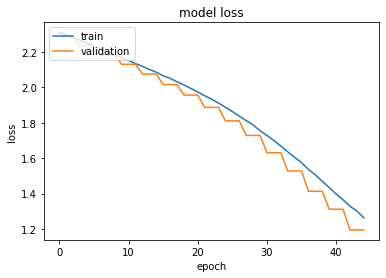

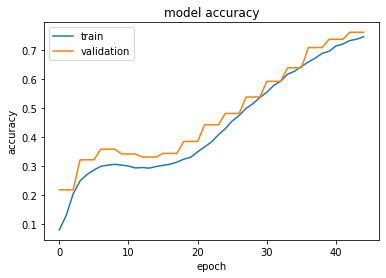

In [7]:
plt.plot(resnet_losses_epoch_train)
plt.plot(resnet_losses_epoch_val)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(resnet_accuracy_epoch_train)
plt.plot(resnet_accuracy_epoch_val)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# DenseNet-121
## Train DenseNet-121

Avoid overfitting and underfitting as much as possible. **Try to get highest validation and test accuracy (at least 65%)**

In [8]:
# You can use the same training mechanism above. Now, you will use DenseNet-121 as your model 
# It modifies the behaviour of modules like BatchNorm and Dropout for training purposes
# Use your own model
for param in densenet.parameters():
    param.requires_grad = False

    
densenet.classifier = nn.Sequential(nn.Linear(densenet.classifier.in_features, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.1),
                                 
                                 nn.Linear(512, 64),
                                 nn.ReLU(),
                                 nn.Dropout(0.1),
                                 nn.Linear(64, 10),
                                 nn.LogSoftmax(dim=1))


batch_size = 32
learning_rate = 2e-5
regularization_rate = 1e-10
n_epochs = 45
use_gpu = True
test_every = 3

criteria = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(densenet.parameters(), lr=learning_rate, momentum=0.9)



densenet.train()
if use_gpu:
    densenet.cuda()
    criteria.cuda()

# Some example diagnostics.

# Loss for every iteration
densenet_losses_iter_train = []
# Loss for epoch (averaging the iteration-wise loss)
densenet_losses_epoch_train = []
densenet_accuracy_iter_train = []
densenet_accuracy_epoch_train = []

densenet_losses_iter_val = []
densenet_losses_epoch_val = []
densenet_accuracy_iter_val = []
densenet_accuracy_epoch_val = []

# Write the training loop
for epoch in range(n_epochs):
    epoch_loss = 0
    epoch_acc = 0
    for data in train_loader:
        optimizer.zero_grad()
        img, label = data
        if use_gpu:
            img = img.cuda()
            label = label.cuda()
        outputs = densenet(img)
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == label).sum().item()
        loss = criteria(outputs, label)
        loss.backward()
        optimizer.step()

        densenet_accuracy_iter_train.append(correct/(len(label)))
        densenet_losses_iter_train.append(loss)
        epoch_loss += loss
        epoch_acc += correct/(len(label))
    densenet_losses_epoch_train.append(epoch_loss/(len(train_loader)))
    densenet_accuracy_epoch_train.append(epoch_acc/(len(train_loader)))
    print("Training Accuracy: {}, Training Loss: {}".format(epoch_acc/(len(train_loader)), epoch_loss/(len(train_loader))))
    if epoch % 3 == 1:
        with torch.no_grad():
            densenet.eval()
            epoch_acc=0
            epoch_loss= 0
            for data in val_loader:              
              img, label = data
              if use_gpu:                
                img = img.cuda()
                label = label.cuda()
              outputs = densenet(img)
              _, predicted = torch.max(outputs, 1)
              correct = (predicted == label).sum().item()
              loss = criteria(outputs, label)
              densenet_accuracy_iter_val.append(correct/(len(label)))
              densenet_losses_iter_val.append(loss)
              epoch_loss += loss
              epoch_acc += correct/(len(label))
            for i in range(3):
              densenet_losses_epoch_val.append(epoch_loss/(len(val_loader)))
              densenet_accuracy_epoch_val.append(epoch_acc/(len(val_loader)))
            print("Validation Accuracy: {}, Validation Loss: {}".format(epoch_acc/(len(val_loader)), epoch_loss/(len(val_loader))))
            
            
    densenet.train()
    
        # Fill the rest...
        


Training Accuracy: 0.18223443223443223, Training Loss: 2.285944938659668
Training Accuracy: 0.18776709401709402, Training Loss: 2.261916160583496
Validation Accuracy: 0.18880208333333334, Validation Loss: 2.2448132038116455
Training Accuracy: 0.18948412698412698, Training Loss: 2.239600896835327
Training Accuracy: 0.19665750915750915, Training Loss: 2.221220016479492
Training Accuracy: 0.21123321123321123, Training Loss: 2.20255970954895
Validation Accuracy: 0.21549479166666666, Validation Loss: 2.187929391860962
Training Accuracy: 0.23599664224664224, Training Loss: 2.185880184173584
Training Accuracy: 0.25179334554334554, Training Loss: 2.1708357334136963
Training Accuracy: 0.2667887667887668, Training Loss: 2.1559455394744873
Validation Accuracy: 0.2916666666666667, Validation Loss: 2.1383793354034424
Training Accuracy: 0.27415293040293043, Training Loss: 2.1398427486419678
Training Accuracy: 0.27777777777777773, Training Loss: 2.1256120204925537
Training Accuracy: 0.276289682539682

## Testing

In [9]:
# You can use the same testing mechanism above. Now, you will use the DenseNet model you trained above 
densenet.eval()
epoch_acc=0
with torch.no_grad():
    for data in test_loader:
        img, label = data
        if use_gpu:
            img = img.cuda()
            label = label.cuda()
        outputs = densenet(img)
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == label).sum().item()
        epoch_acc += correct/(len(label))
        
    print("Test Accuracy: {}".format(epoch_acc/(len(test_loader))))
    # Fill the rest...

Test Accuracy: 0.6799918831168831


### Plot the training and validation losses versus number of iterations or epochs for DenseNet-121 on the same plot and obtain test accuracy

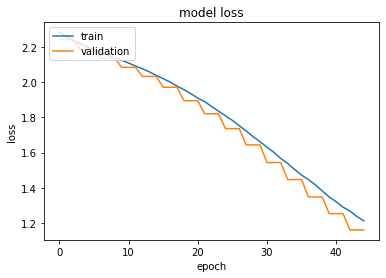

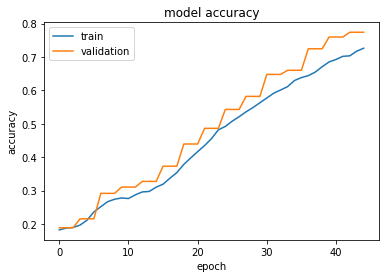

In [10]:
plt.plot(densenet_losses_epoch_train)
plt.plot(densenet_losses_epoch_val)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(densenet_accuracy_epoch_train)
plt.plot(densenet_accuracy_epoch_val)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# BatchNorm Comparison

**Create two models one with batchnorm layers and one without batchnorm layers. Train them. If your YourModel() satisfies any of these conditions, you can use it for comparison.**

In [ ]:
# Define your model with BatchNorm and train it. Skip this if you use YourModel() for this condition.

class WithoutBatchNormModel(nn.Module):
    def __init__(self):
        # TO DO: Your neural network design
        super(WithoutBatchNormModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 20, 9)
        self.conv2 = nn.Conv2d(20, 10, 9)   
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(10 * 50 * 50, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.relu3 = nn.ReLU()        
        self.relu4 = nn.ReLU()    
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.2)
        self.dropout3 = nn.Dropout(0.2)        
        self.dropout4 = nn.Dropout(0.2)     
    def forward(self, x):
        # TO DO: Your neural network design
        x = self.dropout1(self.pool(self.relu1(self.conv1(x))))
        x = self.dropout2(self.pool(self.relu2(self.conv2(x))))
        x = torch.reshape(x, (x.size()[0], -1))
        #print(x.shape)
        x = self.dropout3(self.relu3(self.fc1(x)))
        x = self.dropout4(self.relu4(self.fc2(x)))
        out = self.fc3(x)
        return out



batchnormmodel = WithoutBatchNormModel()


In [ ]:
# Define your model without BatchNorm and train it. Skip this if you use YourModel() for this condition.
# It modifies the behaviour of modules like BatchNorm and Dropout for training purposes
# Use your own model

###  Here are some training parameters which you can tweak


learning_rate = 5e-3
regularization_rate = 1e-10
n_epochs = 20
use_gpu = True
test_every = 3
###
# You may want to tweak them too and you can use different parameter settings for different models. 
# These are just examples
criteria = nn.CrossEntropyLoss()


optimizer = optim.SGD(params=batchnormmodel.parameters(), lr=learning_rate, weight_decay=0.001)
batchnormmodel.train()

if use_gpu:
    batchnormmodel.cuda()
    criteria.cuda()

# Some example diagnostics.

# Loss for every iteration
bn_losses_iter_train = []
# Loss for epoch (averaging the iteration-wise loss)
bn_losses_epoch_train = []
bn_accuracy_iter_train = []
bn_accuracy_epoch_train = []

bn_losses_iter_val = []
bn_losses_epoch_val = []
bn_accuracy_iter_val = []
bn_accuracy_epoch_val = []

# Write the training loop
for epoch in range(n_epochs):
    epoch_loss=0
    epoch_acc = 0
    for data in train_loader:
        batchnormmodel.zero_grad()
        img, label = data
        if use_gpu:
            img = img.cuda()
            label = label.cuda()
        outputs = batchnormmodel(img)
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == label).sum().item()
        loss = criteria(outputs, label)
        loss.backward()
        optimizer.step()

        bn_accuracy_iter_train.append(correct/(len(label)))
        bn_losses_iter_train.append(loss)
        epoch_loss += loss
        epoch_acc += correct/(len(label))
    bn_losses_epoch_train.append(epoch_loss/(len(train_loader)))
    bn_accuracy_epoch_train.append(epoch_acc/(len(train_loader)))
    print("Training Accuracy: {}, Training Loss: {}".format(epoch_acc/(len(train_loader)), epoch_loss/(len(train_loader))))
    if epoch % 3 == 1:
        with torch.no_grad():
            batchnormmodel.eval()
            epoch_acc = 0
            epoch_loss = 0
            for data in val_loader:              
              img, label = data
              if use_gpu:                
                img = img.cuda()
                label = label.cuda()
              outputs = batchnormmodel(img)
              _, predicted = torch.max(outputs, 1)
              correct = (predicted == label).sum().item()
              loss = criteria(outputs, label)
              bn_accuracy_iter_val.append(correct/(len(label)))
              bn_losses_iter_val.append(loss)
              epoch_loss += loss
              epoch_acc += correct/(len(label))
            
            for i in range(3):
              bn_losses_epoch_val.append(epoch_loss/(len(val_loader)))
              bn_accuracy_epoch_val.append(epoch_acc/(len(val_loader)))
            print("Validation Accuracy: {}, Validation Loss: {}".format(epoch_acc/(len(val_loader)), epoch_loss/(len(val_loader))))
            
            
    batchnormmodel.train()
    
        # Fill the rest...
        


Training Accuracy: 0.3206272893772894, Training Loss: 1.820333480834961
Training Accuracy: 0.4477640415140415, Training Loss: 1.5084319114685059
Validation Accuracy: 0.43988715277777773, Validation Loss: 1.576664686203003
Training Accuracy: 0.4922924297924298, Training Loss: 1.385461688041687
Training Accuracy: 0.5395680708180709, Training Loss: 1.2795231342315674
Training Accuracy: 0.5902777777777778, Training Loss: 1.1537851095199585
Validation Accuracy: 0.5946180555555556, Validation Loss: 1.1634347438812256
Training Accuracy: 0.6326694139194139, Training Loss: 1.0405617952346802
Training Accuracy: 0.670825702075702, Training Loss: 0.9576722383499146
Training Accuracy: 0.6866605616605617, Training Loss: 0.8998541235923767
Validation Accuracy: 0.656467013888889, Validation Loss: 1.016116976737976
Training Accuracy: 0.7054716117216118, Training Loss: 0.8444276452064514
Training Accuracy: 0.728021978021978, Training Loss: 0.7884958982467651
Training Accuracy: 0.749465811965812, Trainin

**For each, plot the training and validation losses versus number of iterations or epochs and compare test accuracies.**

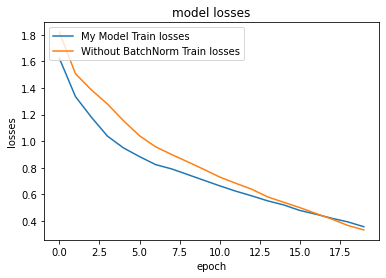

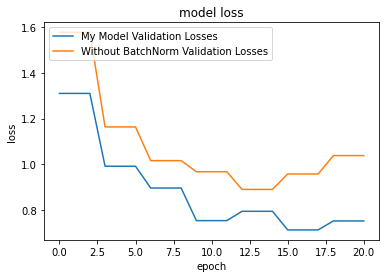

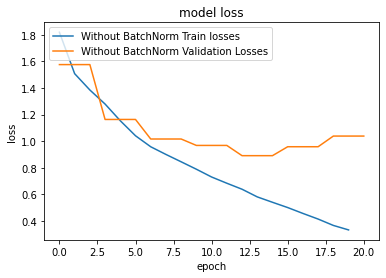

In [ ]:
plt.plot(losses_epoch_train)
plt.plot(bn_losses_epoch_train)
plt.title('model losses')
plt.ylabel('losses')
plt.xlabel('epoch')
plt.legend(['My Model Train losses', 'Without BatchNorm Train losses'], loc='upper left')
plt.show()
# "Loss"
plt.plot(losses_epoch_val)
plt.plot(bn_losses_epoch_val)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['My Model Validation Losses', 'Without BatchNorm Validation Losses'], loc='upper left')
plt.show()


plt.plot(bn_losses_epoch_train)
plt.plot(bn_losses_epoch_val)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Without BatchNorm Train losses', 'Without BatchNorm Validation Losses'], loc='upper left')
plt.show()

In [ ]:
# You can use the same testing mechanism above. Now, you will use the DenseNet model you trained above 
model.eval()
epoch_acc=0
with torch.no_grad():
    for data in test_loader:
        img, label = data
        if use_gpu:
            img = img.cuda()
            label = label.cuda()
        outputs = model(img)
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == label).sum().item()
        epoch_acc += correct/(len(label))
        
    print("My Model Test Accuracy: {}".format(epoch_acc/(len(test_loader))))
    # Fill the rest...




# You can use the same testing mechanism above. Now, you will use the DenseNet model you trained above 
batchnormmodel.eval()
epoch_acc=0
with torch.no_grad():
    for data in test_loader:
        img, label = data
        if use_gpu:
            img = img.cuda()
            label = label.cuda()
        outputs = batchnormmodel(img)
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == label).sum().item()
        epoch_acc += correct/(len(label))
        
    print("Without BatchNorm Test Accuracy: {}".format(epoch_acc/(len(test_loader))))
    # Fill the rest...

My Model Test Accuracy: 0.6491477272727273
Without BatchNorm Test Accuracy: 0.6442775974025974


# Dropout Comparison

**Create two models one with dropout layers and one without dropout layers. Train them. If your YourModel() satisfies any of these conditions, you can use it for comparison.**

In [ ]:
# Define your model with Dropout and train it. Skip this if you use YourModel() for this condition.
# Define your model with BatchNorm and train it. Skip this if you use YourModel() for this condition.

# Define your model with BatchNorm and train it. Skip this if you use YourModel() for this condition.

class WithoutDropOutModel(nn.Module):
    def __init__(self):
        # TO DO: Your neural network design
        super(WithoutDropOutModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 20, 9)
        self.conv2 = nn.Conv2d(20, 10, 9)  
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(10 * 50 * 50, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.relu3 = nn.ReLU()        
        self.relu4 = nn.ReLU()     
        self.conv1_bn = nn.BatchNorm2d(20)
        self.conv2_bn = nn.BatchNorm2d(10)
    def forward(self, x):
        # TO DO: Your neural network design
        x = self.pool(self.relu1(self.conv1_bn(self.conv1(x))))
        x = self.pool(self.relu2(self.conv2_bn(self.conv2(x))))
        x = torch.reshape(x, (x.size()[0], -1))
        #print(x.shape)
        x = self.relu3(self.fc1(x))
        x = self.relu4(self.fc2(x))
        out = self.fc3(x)
        return out





dropoutmodel = WithoutDropOutModel()




In [ ]:
# Define your model without Dropout and train it. Skip this if you use YourModel() for this condition.
# Define your model without BatchNorm and train it. Skip this if you use YourModel() for this condition.
# It modifies the behaviour of modules like BatchNorm and Dropout for training purposes
# Use your own model

learning_rate = 5e-3
regularization_rate = 1e-10
n_epochs = 20
use_gpu = True
test_every = 3
###
# You may want to tweak them too and you can use different parameter settings for different models. 
# These are just examples
criteria = nn.CrossEntropyLoss()

optimizer = optim.SGD(params=dropoutmodel.parameters(), lr=learning_rate, weight_decay=0.001)
dropoutmodel.train()
if use_gpu:
    dropoutmodel.cuda()
    criteria.cuda()

# Some example diagnostics.

# Loss for every iteration
do_losses_iter_train = []
# Loss for epoch (averaging the iteration-wise loss)
do_losses_epoch_train = []
do_accuracy_iter_train = []
do_accuracy_epoch_train = []

do_losses_iter_val = []
do_losses_epoch_val = []
do_accuracy_iter_val = []
do_accuracy_epoch_val = []

# Write the training loop
for epoch in range(n_epochs):
    epoch_loss=0
    epoch_acc = 0
    for data in train_loader:
        dropoutmodel.zero_grad()
        img, label = data
        if use_gpu:
            img = img.cuda()
            label = label.cuda()
        outputs = dropoutmodel(img)
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == label).sum().item()
        loss = criteria(outputs, label)
        loss.backward()
        optimizer.step()

        do_accuracy_iter_train.append(correct/(len(label)))
        do_losses_iter_train.append(loss)
        epoch_loss += loss
        epoch_acc += correct/(len(label))
    do_losses_epoch_train.append(epoch_loss/(len(train_loader)))
    do_accuracy_epoch_train.append(epoch_acc/(len(train_loader)))
    print("Training Accuracy: {}, Training Loss: {}".format(epoch_acc/(len(train_loader)), epoch_loss/(len(train_loader))))
    if epoch % 3 == 1:
        with torch.no_grad():
            dropoutmodel.eval()
            epoch_acc = 0
            epoch_loss = 0
            for data in val_loader:              
              img, label = data
              if use_gpu:                
                img = img.cuda()
                label = label.cuda()
              outputs = dropoutmodel(img)
              _, predicted = torch.max(outputs, 1)
              correct = (predicted == label).sum().item()
              loss = criteria(outputs, label)
              do_accuracy_iter_val.append(correct/(len(label)))
              do_losses_iter_val.append(loss)
              epoch_loss += loss
              epoch_acc += correct/(len(label))
            
            for i in range(3):
              do_losses_epoch_val.append(epoch_loss/(len(val_loader)))
              do_accuracy_epoch_val.append(epoch_acc/(len(val_loader)))
            print("Validation Accuracy: {}, Validation Loss: {}".format(epoch_acc/(len(val_loader)), epoch_loss/(len(val_loader))))
            
            
    dropoutmodel.train()
    
        # Fill the rest...
        


Training Accuracy: 0.42876221001221, Training Loss: 1.5905346870422363
Training Accuracy: 0.5823794261294262, Training Loss: 1.1893404722213745
Validation Accuracy: 0.6243489583333334, Validation Loss: 1.1162586212158203
Training Accuracy: 0.6441544566544566, Training Loss: 1.0155038833618164
Training Accuracy: 0.6807844932844932, Training Loss: 0.902618408203125
Training Accuracy: 0.7181013431013431, Training Loss: 0.8115211129188538
Validation Accuracy: 0.6812065972222222, Validation Loss: 0.9258832335472107
Training Accuracy: 0.7433989621489621, Training Loss: 0.7433616518974304
Training Accuracy: 0.7674374236874236, Training Loss: 0.6828987002372742
Training Accuracy: 0.7824328449328449, Training Loss: 0.6226213574409485
Validation Accuracy: 0.6753472222222222, Validation Loss: 0.9525818824768066
Training Accuracy: 0.8080738705738706, Training Loss: 0.5711612105369568
Training Accuracy: 0.8194444444444445, Training Loss: 0.5276269912719727
Training Accuracy: 0.8426434676434676, Tra

**For each, plot the training and validation losses versus number of iterations or epochs and compare test accuracies.**

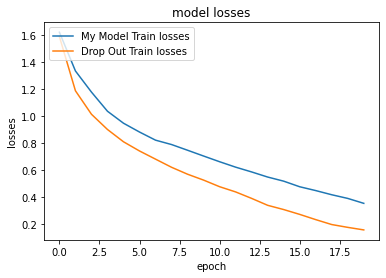

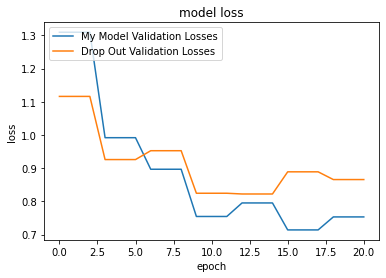

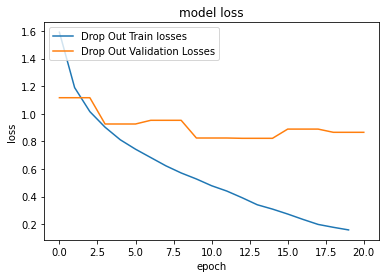

In [ ]:
plt.plot(losses_epoch_train)
plt.plot(do_losses_epoch_train)
plt.title('model losses')
plt.ylabel('losses')
plt.xlabel('epoch')
plt.legend(['My Model Train losses', 'Drop Out Train losses'], loc='upper left')
plt.show()
# "Loss"
plt.plot(losses_epoch_val)
plt.plot(do_losses_epoch_val)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['My Model Validation Losses', 'Drop Out Validation Losses'], loc='upper left')
plt.show()

plt.plot(do_losses_epoch_train)
plt.plot(do_losses_epoch_val)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Drop Out Train losses', 'Drop Out Validation Losses'], loc='upper left')
plt.show()

In [ ]:
# You can use the same testing mechanism above. Now, you will use the DenseNet model you trained above 
model.eval()
epoch_acc=0
with torch.no_grad():
    for data in test_loader:
        img, label = data
        if use_gpu:
            img = img.cuda()
            label = label.cuda()
        outputs = model(img)
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == label).sum().item()
        epoch_acc += correct/(len(label))
        
    print("My Model Test Accuracy: {}".format(epoch_acc/(len(test_loader))))
    # Fill the rest...




# You can use the same testing mechanism above. Now, you will use the DenseNet model you trained above 
dropoutmodel.eval()
epoch_acc=0
with torch.no_grad():
    for data in test_loader:
        img, label = data
        if use_gpu:
            img = img.cuda()
            label = label.cuda()
        outputs = dropoutmodel(img)
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == label).sum().item()
        epoch_acc += correct/(len(label))
        
    print("Without Dropout Test Accuracy: {}".format(epoch_acc/(len(test_loader))))
    # Fill the rest...

My Model Test Accuracy: 0.6491477272727273
Without Dropout Test Accuracy: 0.6200284090909091


# Optimizer Comparison

**Optimize two identical models one with SGD+Momentum and one with Adam. If your training for YourModel() satisfies any of these conditions, you can use it for comparison.**

In [ ]:
# Train your model with SGD+Momentum. Skip this if you use YourModel() for this condition.

        
# Define your model with BatchNorm and train it. Skip this if you use YourModel() for this condition.



adammodel = YourModel()

In [ ]:
# Train your model with Adam. Skip this if you use YourModel() for this condition.
# It modifies the behaviour of modules like BatchNorm and Dropout for training purposes
# Use your own model
learning_rate = 5e-3
regularization_rate = 1e-10
n_epochs = 20
use_gpu = True
test_every = 3
###
# You may want to tweak them too and you can use different parameter settings for different models. 
# These are just examples
criteria = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=adammodel.parameters(), lr=learning_rate, weight_decay=regularization_rate)
adammodel.train()
if use_gpu:
    adammodel.cuda()
    criteria.cuda()

# Some example diagnostics.

# Loss for every iteration
adam_losses_iter_train = []
# Loss for epoch (averaging the iteration-wise loss)
adam_losses_epoch_train = []
adam_accuracy_iter_train = []
adam_accuracy_epoch_train = []

adam_losses_iter_val = []
adam_losses_epoch_val = []
adam_accuracy_iter_val = []
adam_accuracy_epoch_val = []

# Write the training loop
for epoch in range(n_epochs):
    epoch_loss=0
    epoch_acc = 0
    for data in train_loader:
        adammodel.zero_grad()
        img, label = data
        if use_gpu:
            img = img.cuda()
            label = label.cuda()
        outputs = adammodel(img)
        _, predicted = torch.max(outputs, 1)
        #c = (predicted == label).squeeze()
        correct = (predicted == label).sum().item()
        loss = criteria(outputs, label)
        loss.backward()
        optimizer.step()

        adam_accuracy_iter_train.append(correct/(len(label)))
        adam_losses_iter_train.append(loss)
        epoch_loss += loss
        epoch_acc += correct/(len(label))
    adam_losses_epoch_train.append(epoch_loss/(len(train_loader)))
    adam_accuracy_epoch_train.append(epoch_acc/(len(train_loader)))
    print("Training Accuracy: {}, Training Loss: {}".format(epoch_acc/(len(train_loader)), epoch_loss/(len(train_loader))))
    if epoch % 3 == 1:
        with torch.no_grad():
            adammodel.eval()
            epoch_acc=0
            for data in val_loader:              
              img, label = data
              if use_gpu:                
                img = img.cuda()
                label = label.cuda()
              outputs = adammodel(img)
              _, predicted = torch.max(outputs, 1)
              #c = (predicted == labels).squeeze()
              correct = (predicted == label).sum().item()
              loss = criteria(outputs, label)
              adam_accuracy_iter_val.append(correct/(len(label)))
              adam_losses_iter_val.append(loss)
              epoch_loss += loss
              epoch_acc += correct/(len(label))
              
            for i in range(3):
              adam_losses_epoch_val.append(epoch_loss/(len(val_loader)))
              adam_accuracy_epoch_val.append(epoch_acc/(len(val_loader)))
            print("Validation Accuracy: {}, Validation Loss: {}".format(epoch_acc/(len(val_loader)), epoch_loss/(len(val_loader))))
            
            
    adammodel.train()
    
        # Fill the rest...

Training Accuracy: 0.25488400488400487, Training Loss: 3.3211026191711426
Training Accuracy: 0.28926282051282054, Training Loss: 1.8701351881027222
Validation Accuracy: 0.298828125, Validation Loss: 12.474546432495117
Training Accuracy: 0.31452228327228327, Training Loss: 1.8575522899627686
Training Accuracy: 0.3064331501831502, Training Loss: 1.862987995147705
Training Accuracy: 0.3231837606837607, Training Loss: 1.7799335718154907
Validation Accuracy: 0.36480034722222227, Validation Loss: 11.828481674194336
Training Accuracy: 0.3269612332112332, Training Loss: 1.7752660512924194
Training Accuracy: 0.3479471916971917, Training Loss: 1.7219618558883667
Training Accuracy: 0.35286935286935284, Training Loss: 1.7050209045410156
Validation Accuracy: 0.3561197916666667, Validation Loss: 11.35506820678711
Training Accuracy: 0.34489468864468864, Training Loss: 1.7364126443862915
Training Accuracy: 0.363476800976801, Training Loss: 1.661404013633728
Training Accuracy: 0.3805326617826618, Train

**For each, plot the training and validation losses versus number of iterations or epochs and compare test accuracies**

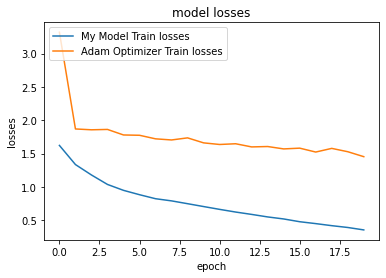

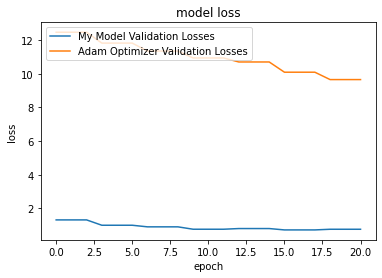

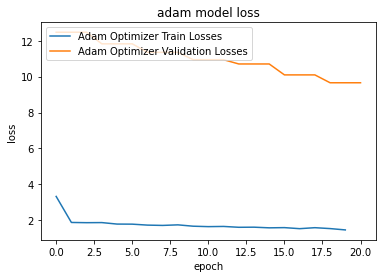

In [ ]:
plt.plot(losses_epoch_train)
plt.plot(adam_losses_epoch_train)
plt.title('model losses')
plt.ylabel('losses')
plt.xlabel('epoch')
plt.legend(['My Model Train losses', 'Adam Optimizer Train losses'], loc='upper left')
plt.show()
# "Loss"
plt.plot(losses_epoch_val)
plt.plot(adam_losses_epoch_val)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['My Model Validation Losses', 'Adam Optimizer Validation Losses'], loc='upper left')
plt.show()

plt.plot(adam_losses_epoch_train)
plt.plot(adam_losses_epoch_val)
plt.title('adam model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Adam Optimizer Train Losses', 'Adam Optimizer Validation Losses'], loc='upper left')
plt.show()

In [ ]:
# You can use the same testing mechanism above. Now, you will use the DenseNet model you trained above 

print("My Model Test Accuracy: {}".format(mymodel_testacc))
    # Fill the rest...




# You can use the same testing mechanism above. Now, you will use the DenseNet model you trained above 
model.eval()
epoch_acc=0
with torch.no_grad():
    for data in test_loader:
        img, label = data
        if use_gpu:
            img = img.cuda()
            label = label.cuda()
        outputs = dropoutmodel(img)
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == label).sum().item()
        epoch_acc += correct/(len(label))
        
    print("Adam Optimizer Test Accuracy: {}".format(epoch_acc/(len(test_loader))))
    # Fill the rest...

My Model Test Accuracy: 0.6491477272727273
Adam Optimizer Test Accuracy: 0.6200284090909091


#### After you have completed the training, save your best model using the following command
#### Upload your best model to Google Drive and copy your link here: *https://drive.google.com/file/d/119N2yTWfu8Dt5HE49RGhT5yx5eUYNrGP/view?usp=sharing*

In [ ]:
student_id = 504191509
torch.save(model.state_dict(), '/content/{}.pth'.format(student_id))